In [1]:
# load the data
import numpy as np
import pandas as pd

df = pd.read_csv(f'./Data/spambase.csv')
features = np.array(df.drop("Class", axis=1))
target = np.array(df["Class"])

print(features.shape)
print("done")


(4601, 57)
done


In [2]:
# unc over time test fnuction
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from Algo.a_RF import get_prob_matrix

def unc_over_time(features,target, unc_method, episodes=10, runs=10, seed=42):
    ac_multi = []
    t_multi = [] 
    e_multi = [] 
    a_multi = [] 
    for run in range(runs):
        x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.33, shuffle=True, random_state=seed*run)

        ep_len = int(len(x_train) / episodes)

        acc_hist = []
        unc_t_hist = []
        unc_e_hist = []
        unc_a_hist = []

        for i in range(1,episodes+1):
            # get episode data
            x_train_ep = x_train[0:ep_len*i]
            y_train_ep = y_train[0:ep_len*i]

            # train model
            n_estimators = 20
            model = None
            model = RandomForestClassifier(bootstrap=True,
                criterion="entropy",
                max_depth=10,
                n_estimators=n_estimators,
                # max_features= "sqrt",
                # min_samples_leaf= pram['min_samples_leaf'],
                random_state=seed*run,
                verbose=0,
                warm_start=True)
            model.fit(x_train_ep, y_train_ep)

            # get acc and unc
            acc = model.score(x_test, y_test)
            acc_hist.append(acc)

            porb_matrix = get_prob_matrix(model, x_test, n_estimators, 0) # 1 is laplace
            total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc_method(porb_matrix)
            unc_t_hist.append(total_uncertainty.mean())
            unc_e_hist.append(epistemic_uncertainty.mean())
            unc_a_hist.append(aleatoric_uncertainty.mean())
        ac_multi.append(acc_hist)
        t_multi.append(unc_t_hist) 
        e_multi.append(unc_e_hist) 
        a_multi.append(unc_a_hist)

    ac_multi = np.array(ac_multi).mean(axis=0)
    t_multi = np.array(t_multi).mean(axis=0)
    e_multi = np.array(e_multi).mean(axis=0)
    a_multi = np.array(a_multi).mean(axis=0)
    return ac_multi, t_multi, e_multi, a_multi


In [3]:
# plot unc over time function
import matplotlib.pyplot as plt

def plot_unc(ac, t, e, a):
    fig, axs = plt.subplots(1,3)
    fig.set_figheight(5)
    fig.set_figwidth(20)

    steps = np.arange(0, len(ac),1)

    for i, (unc, unc_color, unc_name) in enumerate(zip([a, e, t], ["orange", "blue", "black"], ["Aleatoric", "Epistemic", "Total"])):
        color = 'tab:red'
        axs[i].set_xlabel('episodes')
        axs[i].set_ylabel('Accuracy', color=color)
        axs[i].plot(steps, ac, color=color)
        # ax1.tick_params(axis='y', labelcolor=color)
        ax2 = axs[i].twinx()
        # plt.plot(t_list)
        ax2.set_ylabel(f"Uncertainty {unc_name}", color=unc_color)  # we already handled the x-label with ax1
        # ax2.plot(t, t_list, color=color)
        # ax2.plot(t, e_list, color="black")
        ax2.plot(steps, unc, color=unc_color)
        fig.tight_layout()

(50,)


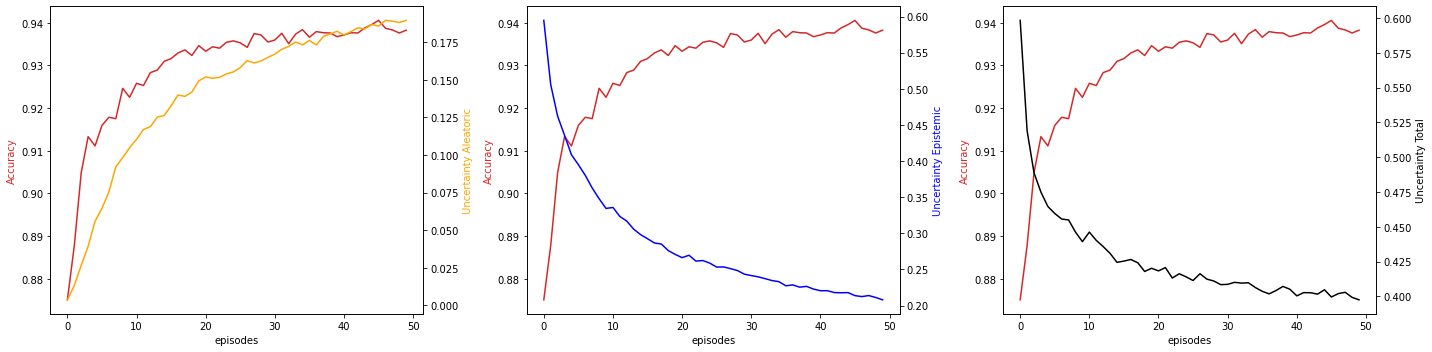

In [7]:
import UncertaintyM as unc

ac, t, e, a = unc_over_time(features,target, unc.uncertainty_ent, episodes=50)
print(t.shape)
plot_unc(ac, t, e, a)

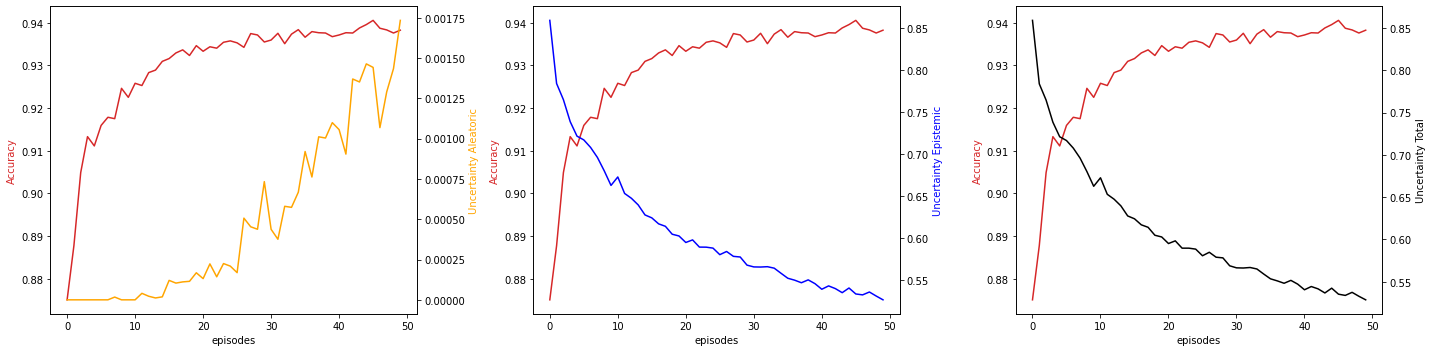

In [8]:
ac, t, e, a = unc_over_time(features,target, unc.uncertainty_set16, episodes=50)
plot_unc(ac, t, e, a)

In [1]:
import UncertaintyM as unc
ac, t, e, a = unc_over_time(features,target, unc.uncertainty_set15_convex, episodes=50)
plot_unc(ac, t, e, a)

NameError: name 'unc_over_time' is not defined